In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=77ffe866c740b45c740a26579858eb003b6568fe1c97ca7a81edcdd95785b740
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 12.3 GB  | Proc size: 98.7 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total 15360MB


In [ ]:
!kill -9 -1    # if Util is greater than 0%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)

EPOCHS = 400
BATCH_SIZE = 200

사용하는 Device :  cuda


In [ ]:
#### colab에서 링크로 데이터 다운로드할때 안되면 이렇게 하면 된다고 함
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
trainset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/colab/MNIST', train = True,
                                        download = True, transform = None)

testset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/colab/MNIST', train = False,
                                        download = True, transform = None)

hdf5_file = h5py.File('/content/drive/MyDrive/colab/MNIST/mnist.hdf5', 'w')

train_data = trainset.data.numpy()
train_labels = trainset.targets.numpy()
test_data = testset.data.numpy()
test_labels = testset.targets.numpy()

train_data = (train_data / 255.0 - 0.5) / 0.5
test_data = (test_data / 255.0 - 0.5) / 0.5

hdf5_file.create_dataset('train_data', data=train_data)
hdf5_file.create_dataset('train_labels', data=train_labels)
hdf5_file.create_dataset('test_data', data=test_data)
hdf5_file.create_dataset('test_labels', data=test_labels)

hdf5_file.close()

print("MNIST 데이터를 HDF5 파일로 변환 완료.")

MNIST 데이터를 HDF5 파일로 변환 완료.


In [ ]:
hdf5_file = h5py.File('/content/drive/MyDrive/colab/MNIST/mnist.hdf5', 'r')

train_data = hdf5_file['train_data'][:]
train_labels = hdf5_file['train_labels'][:]

test_data = hdf5_file['test_data'][:]
test_labels = hdf5_file['test_labels'][:]

hdf5_file.close()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)

In [ ]:
sample, label = next(iter(trainloader))

min_val = sample.min().item()
max_val = sample.max().item()

print("최소값:", min_val)
print("최대값:", max_val)

최소값: -1.0
최대값: 1.0


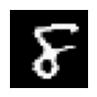

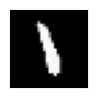

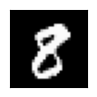

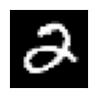

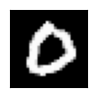

In [ ]:
def imshow_grid(img):
    width = 1
    height = 1
    plt.figure(figsize=(width, height))

    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img * 0.5) / 0.5    # 정규화 데이터 원상복구
    npimg = img.numpy()    # torch tensor to numpy 원상복구
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # mnist 데이터셋은 (channel, width, height) 형태의 shape을 가지고 있음. imshow를 위해 차원의 순서 바꾸기
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

for i in range(0,5):
    imshow_grid(sample[i])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_space):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(image_size, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, 1),
            nn.Sigmoid())

    def forward(self, input_x):
        x = self.features(input_x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_space, hidden_space, image_size):
        super(Generator, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(latent_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, image_size),
            nn.Tanh())

    def forward(self, input_x):
        x = self.features(input_x)
        return x


In [ ]:
im_size = 784    # 28 * 28
hidden_size = 256
latent_size = 100    # generator는 latent space에서 무작위한 벡터를 입력으로 받아 이미지와 같은 데이터를 생성함

Dis_net = Discriminator(image_size = im_size, hidden_space = hidden_size).to(DEVICE)
Gen_net = Generator(image_size = im_size, hidden_space = hidden_size, latent_space = latent_size).to(DEVICE)

d_optimizer = optim.Adam(Dis_net.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(Gen_net.parameters(), lr = 0.0002)

In [ ]:
def train(generator, discriminator, train_loader, optimizer_d, optimizer_g):

    generator.train()
    discriminator.train()

    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)

        # ==========Optimize discriminator==========#

        optimizer_d.zero_grad()

        noise_samples_d = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)

        discri_value = discriminator(data.view(-1, 28*28))
        loss_real = -1 * torch.log(discri_value)

        gene_value = discriminator(generator(noise_samples_d))
        loss_fake = -1 * torch.log(1.0 - gene_value)

        loss_d = (loss_real + loss_fake).mean()

        loss_d.backward()
        optimizer_d.step()


        # ==========Optimize generator============= #

        optimizer_g.zero_grad()

        noise_samples_g = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)

        fake_value = discriminator(generator(noise_samples_g))
        loss_generator = -1 * torch.log(fake_value).mean()

        loss_generator.backward()
        optimizer_g.step()

  0%|          | 0/400 [00:00<?, ?it/s]

epoch 20 / 400


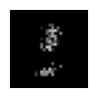

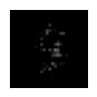

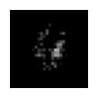

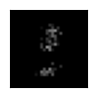

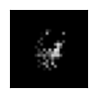

epoch 40 / 400


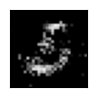

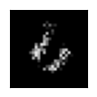

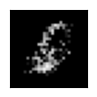

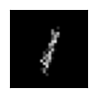

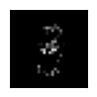

epoch 60 / 400


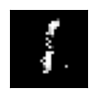

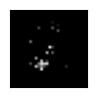

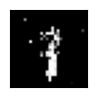

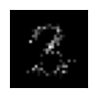

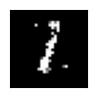

epoch 80 / 400


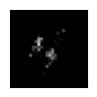

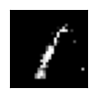

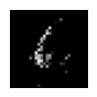

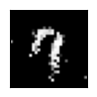

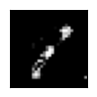

epoch 100 / 400


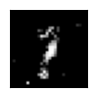

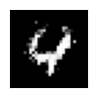

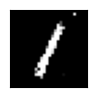

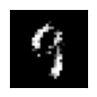

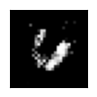

epoch 120 / 400


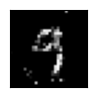

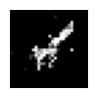

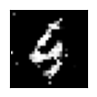

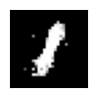

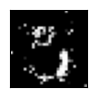

epoch 140 / 400


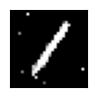

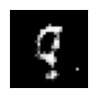

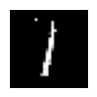

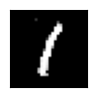

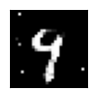

epoch 160 / 400


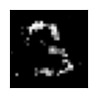

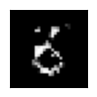

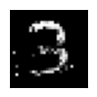

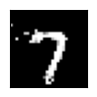

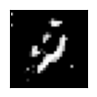

epoch 180 / 400


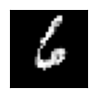

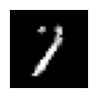

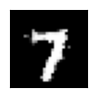

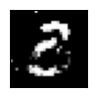

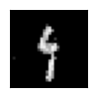

epoch 200 / 400


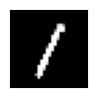

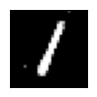

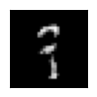

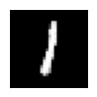

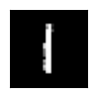

epoch 220 / 400


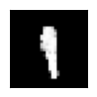

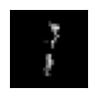

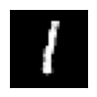

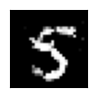

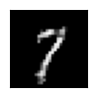

epoch 240 / 400


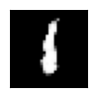

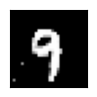

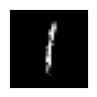

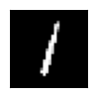

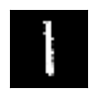

epoch 260 / 400


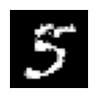

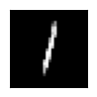

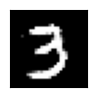

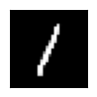

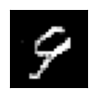

epoch 280 / 400


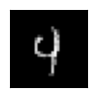

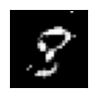

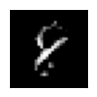

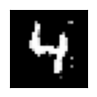

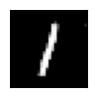

epoch 300 / 400


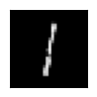

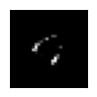

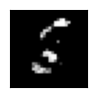

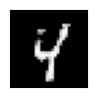

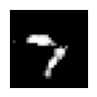

epoch 320 / 400


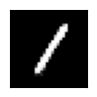

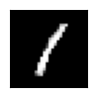

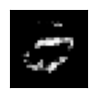

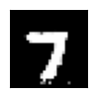

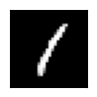

epoch 340 / 400


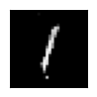

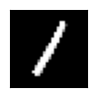

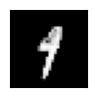

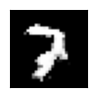

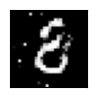

epoch 360 / 400


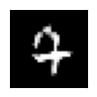

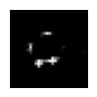

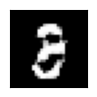

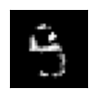

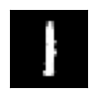

epoch 380 / 400


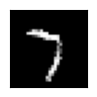

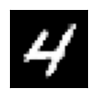

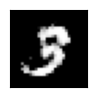

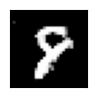

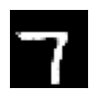

epoch 400 / 400


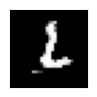

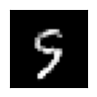

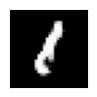

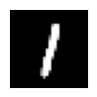

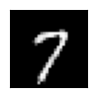

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train(Gen_net, Dis_net, trainloader, d_optimizer, g_optimizer)

    if (epoch+1)%20 == 0:
        print('epoch %i / 400' % (epoch+1))

        noise_sam = torch.randn(16, latent_size).to(DEVICE)

        for i in range(0,5):
            imshow_grid(Gen_net(noise_sam[i]).view(-1, 1, 28, 28))

        print("\n")

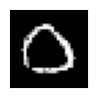

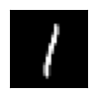

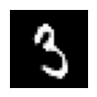

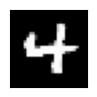

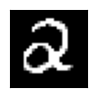

In [ ]:
# For test after training
vis_loader = torch.utils.data.DataLoader(testset, 16, True)
img_vis, label_vis = next(iter(vis_loader))
for i in range(0,5):
    imshow_grid(img_vis[i])

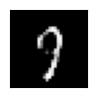

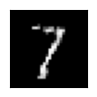

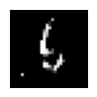

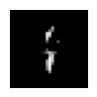

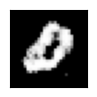

In [ ]:
# Make samples by using trained generator model.
sample_noise = torch.randn(16, latent_size).to(DEVICE)
for i in range(0,5):
    imshow_grid(Gen_net(sample_noise[i]).view(-1, 1, 28, 28))